In [1]:
import os
import sys

import mat73
import numpy as np
import scipy
import torch
import torch.nn.functional as F
from prettytable import PrettyTable

from torch.optim import Adam

from torch.utils.data import Dataset
from tqdm.auto import tqdm

from umap import UMAP
from datetime import datetime
from neurorobotics_dl.models import PrototypicalModel, GCN_GRU_sequence_fxdD,EEGNet
from neurorobotics_dl.metric_learning.sampler import BaseSampler,EpisodicSampler
from neurorobotics_dl.metric_learning import train,get_all_embeddings
from neurorobotics_dl.metric_learning.visualization import visualize_embeddings,visualize_embeddings3D,compare_embeddings
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from joblib import dump


class MyDataset(Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index],self.y[index]
    
    def __len__(self):
        return len(self.X)

class Event():
 START = 1
 RIGHT_HAND = 769
 LEFT_HAND = 770
 BOTH_FEET = 771
 BOTH_HANDS = 773
 CONT_FEEDBACK = 781
 REST = 783
 FIXATION = 786
 HIT = 897
 MISS = 898
 TIMEOUT = 899

 """_____________________________(EDITABLE) EXPERIMENT OPTIONS_____________________________"""
## Data Processing options
DATA_PATH = r'/home/palatella/workspace/cBCI-data/all_subjects/preprocessed'
OUT_PATH = r'/home/palatella/workspace/cBCI-MI-bhbf/model'
LOG_PATH = r'/home/palatella/workspace/cBCI-MI-bhbf/logs'
now = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(OUT_PATH,f'all_subjects_{now}')
log_dir = os.path.join(LOG_PATH,f'all_subjects_{now}')

DO_MACRO = True

NUM_SUBJECT= 2

RANDOM_SEED = 42 # Set it to None #TODO to enable fully random behaviour


LABEL_MAP = { 0:'Both Hands',1:'Both Feets'} # Optional mapping (after dropping unwanted labels)

NORMALIZE = 'zscore' # Data normalization applied at the end of the processing. Available options are 'zscore', None

## Model options

DEVICE = 'cuda'

# TGCN Params
GCN_HIDDEN_DIMS = [128]
GCN_OUTPUT_DIM = 16
GCN_ACTIVATION = F.leaky_relu
GRU_HIDDEN_UNITS = 128
GCN_DROPOUT = 0.5
GRU_DROPOUT = 0.3

# EEGNet Params
CONV_DROPOUT = 0.5
F1 = 8
D = 2
F2 = 16
EMBEDDING_DIM = 32

## Training options
METRIC = 'cosine'
LR = 1e-2
ES_PATIENCE = 5
ES_MIN_DELTA = 1e-4

NUM_EPOCHS = 50
EVAL_BATCH_SIZE = 128

N_SUPPORT = 50
N_QUERY = 60
N_EPISODES = 500
MAX_GRAD_NORM = 1
NUM_CLASSES = 2

LOG_INTERVAL = 1

NUM_CHANNELS = 32
# OPTIMIZER = Adam
# OPTIMIZER_OPTIONS = {"lr":LR}
# SCHEDULER = LinearLR
# SCHEDULER_OPTIONS = {'start_factor':1,'end_factor':LR*1e-2,'total_iters':NUM_EPOCHS}

USE_WANDB = False

fs = 512
windowShift = int(0.0625 * fs)
windowLen = int(1 * fs)
samplesBeforeOnset = int(0. * fs)


In [2]:
windows = dict()
winlabels = dict()


for split in ['train','val','test']:
    subj=mat73.loadmat(os.path.join(DATA_PATH,f'dataset_{split}.mat'))['subj']

    eeg = np.expand_dims(subj['eeg'].T,1)
    settings = subj['settings']
    triggers = subj['triggers']
    triggers['pos'] = triggers['pos'].astype(int)
    triggers['type'] = triggers['type'].astype(int)
    session_delims = subj['session_delims']
    trial_starts = triggers['pos'][(triggers['type']==Event.CONT_FEEDBACK)]
    trial_ends = triggers['pos'][(triggers['type']==Event.HIT)|
                                (triggers['type']==Event.MISS)|
                                (triggers['type']==Event.TIMEOUT)]
    trial_labels = triggers['type'][(triggers['type']==Event.REST)|
                                    (triggers['type']==Event.BOTH_FEET)|
                            (triggers['type']==Event.BOTH_HANDS)]
    indices = []
    labels = []

    
    mask = (trial_labels==Event.BOTH_FEET)|(trial_labels==Event.BOTH_HANDS)
    trial_starts = trial_starts[mask]
    trial_ends = trial_ends[mask]
    trial_labels = trial_labels[mask]

    nTrialsTot = 0
    for i in range(len(trial_starts)):
        t_start = trial_starts[i]-samplesBeforeOnset
        t_end = trial_ends[i]
        assert t_start < t_end
        trial_idx = []
        while t_start + windowLen < t_end:
            trial_idx.append((t_start,t_start+windowLen))
            nTrialsTot +=1
            t_start += windowShift
        labels.append(0 if trial_labels[i]==Event.BOTH_HANDS else 1) ## FIXME per pigrizia non faccio mappe ma sottraggo banalmente 769 (RIGHT_HAND)
        indices.append(trial_idx)
    num_features = 1
    nChannels = NUM_CHANNELS
    windows[split] = np.zeros((nTrialsTot,nChannels,num_features,windowLen),dtype = np.float32)
    winlabels[split] = np.zeros(nTrialsTot,dtype = np.int64)

    seq = 0
    for i,idxlist in enumerate(indices):
        for start,end in idxlist:
            windows[split][seq,:,:] = eeg[:,:,start:end]
            winlabels[split][seq] = labels[i]
            seq+=1

In [3]:
if NORMALIZE is not None:
    if NORMALIZE=='zscore':
        mu = windows['train'].mean(axis=(0,3),keepdims=True)
        sigma = windows['train'].std(axis=(0,3),keepdims=True)

        windows['train'] = (windows['train']-mu)/sigma
        windows['val'] = (windows['val']-mu)/sigma
        windows['test'] = (windows['test']-mu)/sigma
    else:
        mu,sigma = 0,1

train_set = MyDataset(windows['train'],winlabels['train'])
val_set = MyDataset(windows['val'],winlabels['val'])
test_set = MyDataset(windows['test'],winlabels['test'])

In [4]:
# Reading configs
device = DEVICE

metric = METRIC
learning_rate = LR
num_epochs = NUM_EPOCHS
n_support = N_SUPPORT
n_query = N_QUERY
n_episodes = N_EPISODES
n_classes = NUM_CLASSES
eval_batch_size = EVAL_BATCH_SIZE
max_grad_norm = MAX_GRAD_NORM

es_patience = ES_PATIENCE
es_min_delta = ES_MIN_DELTA

log_interval = LOG_INTERVAL
use_wandb = USE_WANDB


# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)

# The train_eval_sampler is used to computer prototypes over the full dataset
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

## Create model	

# T-GCN
# nChannels = 16
# gcn_input_dim = 1
# gcn_hidden_dims = GCN_HIDDEN_DIMS
# gcn_output_dim = GCN_OUTPUT_DIM
# gcn_activation = GCN_ACTIVATION
# gru_hidden_units = GRU_HIDDEN_UNITS
# gcn_dropout = GRU_DROPOUT
# gru_dropout = GCN_DROPOUT
# num_classes = NUM_CLASSES

# net = GCN_GRU_sequence_fxdD(16,
#                         gcn_input_dim,
#                         gcn_hidden_dims,
#                         gcn_output_dim,
#                         gcn_activation,
#                         gru_hidden_units,
#                         gcn_dropout,
#                         gru_dropout,
#                         )

# EEGNet
nSamples = windowLen
nChannels = NUM_CHANNELS
embedding_dim = EMBEDDING_DIM
dropout = CONV_DROPOUT
f1 = F1
d = D
f2 = F2
net = EEGNet(embedding_dim, 
             Chans = nChannels, 
             Samples = nSamples,
             dropoutRate = dropout,
             kernLength = nSamples//2,
             F1 = f1, 
             D = d, 
             F2 = f2,)

model = PrototypicalModel(net,metric).to('cuda')

print('Model Parameters: ')
model_table = PrettyTable()
model_table.field_names = ["Layer", "Params", "Shape", "Trainable"]
tot_params = 0
for name,param in model.named_parameters():
    model_table.add_row([name,param.numel(),param.shape,param.requires_grad])
    tot_params += param.numel()
model_table.add_row(['Total',tot_params,'',''])
print(model_table)

Model Parameters: 
+-----------------------+--------+-----------------------------+-----------+
|         Layer         | Params |            Shape            | Trainable |
+-----------------------+--------+-----------------------------+-----------+
|    net.conv.weight    |  2048  |  torch.Size([8, 1, 1, 256]) |    True   |
|     net.bn1.weight    |   8    |       torch.Size([8])       |    True   |
|      net.bn1.bias     |   8    |       torch.Size([8])       |    True   |
| net.depth_conv.weight |  512   |  torch.Size([16, 1, 32, 1]) |    True   |
|     net.bn2.weight    |   16   |       torch.Size([16])      |    True   |
|      net.bn2.bias     |   16   |       torch.Size([16])      |    True   |
| net.point_conv.weight |  4096  | torch.Size([16, 16, 1, 16]) |    True   |
|     net.bn3.weight    |   16   |       torch.Size([16])      |    True   |
|      net.bn3.bias     |   16   |       torch.Size([16])      |    True   |
|     net.fc.weight     |  8192  |    torch.Size([32, 256

In [5]:
train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )

Beginning training


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/home/palatella/workspace/neurorobotics-dl/neurorobotics_dl/metric_learning/sampler.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  query_source = torch.tensor(query_source)


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1/50: Train loss: 0.6478989720344543 - Val loss: 0.6776226162910461 - Val acc: 0.6328125


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2/50: Train loss: 0.6162011027336121 - Val loss: 0.6623608469963074 - Val acc: 0.6171875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3/50: Train loss: 0.4935171902179718 - Val loss: 0.6458826661109924 - Val acc: 0.65625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4/50: Train loss: 0.5019777417182922 - Val loss: 0.631904661655426 - Val acc: 0.6015625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5/50: Train loss: 0.49703410267829895 - Val loss: 0.6289668083190918 - Val acc: 0.6484375


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 6/50: Train loss: 0.5347344279289246 - Val loss: 0.6241246461868286 - Val acc: 0.6875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 7/50: Train loss: 0.5606762170791626 - Val loss: 0.6122415661811829 - Val acc: 0.7734375


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 8/50: Train loss: 0.5023218989372253 - Val loss: 0.61960768699646 - Val acc: 0.640625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 9/50: Train loss: 0.5832860469818115 - Val loss: 0.6120753884315491 - Val acc: 0.6484375


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 10/50: Train loss: 0.4649219214916229 - Val loss: 0.6073394417762756 - Val acc: 0.671875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 11/50: Train loss: 0.6436888575553894 - Val loss: 0.5989386439323425 - Val acc: 0.7265625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 12/50: Train loss: 0.5703402757644653 - Val loss: 0.6046189069747925 - Val acc: 0.65625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 13/50: Train loss: 0.6455058455467224 - Val loss: 0.5972782373428345 - Val acc: 0.71875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 14/50: Train loss: 0.5277893543243408 - Val loss: 0.6033979058265686 - Val acc: 0.6875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 15/50: Train loss: 0.6166980862617493 - Val loss: 0.595093309879303 - Val acc: 0.7265625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 16/50: Train loss: 0.521659791469574 - Val loss: 0.5923606157302856 - Val acc: 0.6953125


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 17/50: Train loss: 0.5364241003990173 - Val loss: 0.6054490804672241 - Val acc: 0.6484375


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 18/50: Train loss: 0.45386967062950134 - Val loss: 0.602936327457428 - Val acc: 0.6328125


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 19/50: Train loss: 0.5448572039604187 - Val loss: 0.5832513570785522 - Val acc: 0.671875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 20/50: Train loss: 0.5796334147453308 - Val loss: 0.5903348326683044 - Val acc: 0.75


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 21/50: Train loss: 0.3968552052974701 - Val loss: 0.6019342541694641 - Val acc: 0.7421875


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 22/50: Train loss: 0.5379334092140198 - Val loss: 0.6067695021629333 - Val acc: 0.7109375


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 23/50: Train loss: 0.6442789435386658 - Val loss: 0.5914188027381897 - Val acc: 0.703125


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

Epoch 24/50: Train loss: 0.6271800398826599 - Val loss: 0.5924316644668579 - Val acc: 0.65625
Early stopping
Finished training.


# Analysis

In [6]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))

<All keys matched successfully>

In [7]:
model.to('cpu').compile()
def totime():
    with torch.no_grad():
        return model.compute_embeddings(torch.tensor(windows['train'][0]).unsqueeze(0).to('cpu'))
%timeit totime()

2.53 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


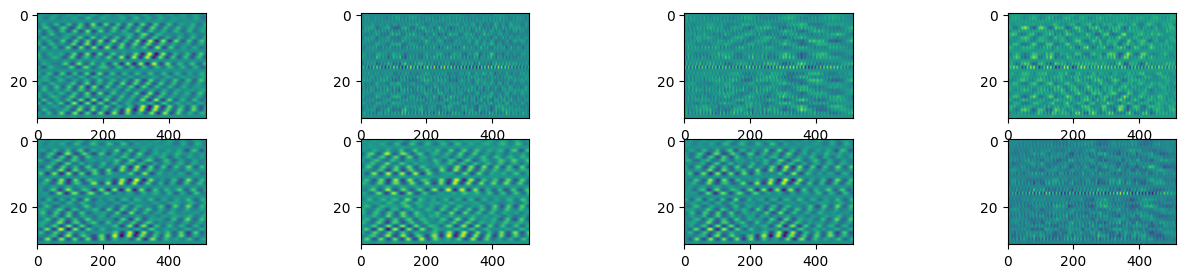

In [8]:
with torch.no_grad():
    o = model.net.conv(torch.tensor(windows['train'][0]).unsqueeze(0).to('cpu').permute(0,2,1,3)).squeeze().cpu().numpy()
fig = plt.figure(figsize = (16,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    
    plt.imshow(o[i,:,:],aspect=10)
plt.show()

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

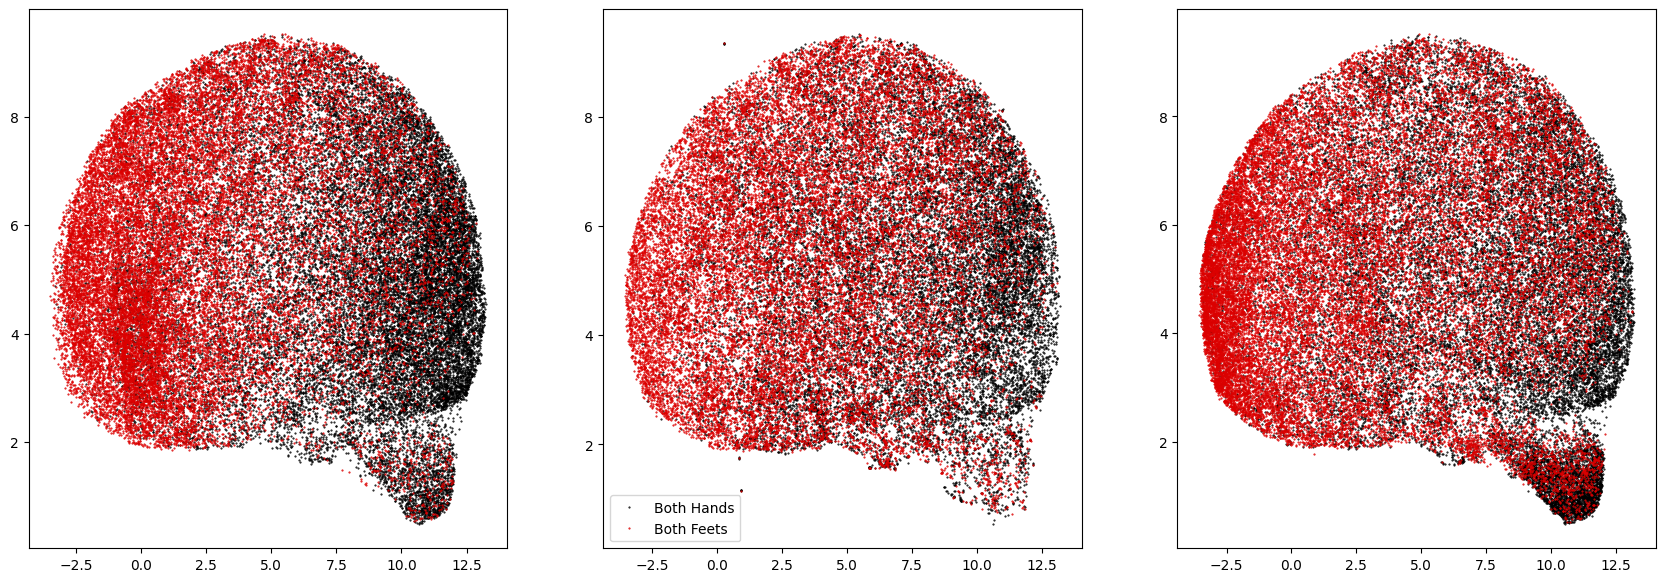

In [9]:
model.to('cuda')
n_components = 2
train_embeddings, train_labels = get_all_embeddings(train_sampler, model,device)
train_embeddings = train_embeddings.cpu().numpy()
train_labels = train_labels.cpu().numpy()

val_embeddings, val_labels = get_all_embeddings(val_sampler, model,device)
val_embeddings = val_embeddings.cpu().numpy()
val_labels = val_labels.cpu().numpy()

test_embeddings, test_labels = get_all_embeddings(test_sampler, model,device)
test_embeddings = test_embeddings.cpu().numpy()
test_labels = test_labels.cpu().numpy()

tr_len = len(train_embeddings)
val_len = tr_len+len(val_embeddings)
all_embeddings = np.concatenate([train_embeddings,val_embeddings,test_embeddings])
transform = UMAP(metric=metric)
all_embeddings_umap = transform.fit_transform(all_embeddings)
compare_embeddings(all_embeddings_umap[:tr_len],
                   all_embeddings_umap[tr_len:val_len],
                   train_labels,
                   val_labels,
                   embeddings3 = all_embeddings_umap[val_len:],
                   labels3=test_labels,label_mappings = LABEL_MAP)

In [10]:
centroids = (train_embeddings[train_labels==0].mean(axis=0),train_embeddings[train_labels==1].mean(axis=0))
centroids = np.stack(centroids)

def compute_distances(centroids,embeddings):
    if metric == 'euclidean':
        _dist = [np.sum((embeddings - centroids[i])**2, dim=1) for i in range(centroids.shape[0])]
    else:
        _dist = [1-np.dot(embeddings, centroids[i])/(np.linalg.norm(embeddings)*np.linalg.norm(centroids[i]))for i in range(centroids.shape[0])]
    dist = np.stack(_dist,axis=1)
    return dist

train_preds = compute_distances(centroids,train_embeddings).argmin(axis=1)
val_preds = compute_distances(centroids,val_embeddings).argmin(axis=1)
test_preds = compute_distances(centroids,test_embeddings).argmin(axis=1)

print(f'Train Accuracy: {(train_preds==train_labels).mean()*100:.2f}%')
print(f'  Val Accuracy: {(val_preds==val_labels).mean()*100:.2f}%')
print(f' Test Accuracy: {(test_preds==test_labels).mean()*100:.2f}%')

Train Accuracy: 76.61%
  Val Accuracy: 66.49%
 Test Accuracy: 68.40%


In [11]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(train_embeddings, train_labels)

train_preds = clf.predict(train_embeddings)
print(f'Train Accuracy: {(train_preds==train_labels).mean()*100:.2f}%')
val_preds = clf.predict(val_embeddings)
print(f'  Val Accuracy: {(val_preds==val_labels).mean()*100:.2f}%')
test_preds = clf.predict(test_embeddings)
print(f' Test Accuracy: {(test_preds==test_labels).mean()*100:.2f}%')

dump(clf, os.path.join(output_dir,'qda.joblib') )
np.savez(os.path.join(output_dir,'mean_std.npz'),mu=mu,sigma=sigma)


Train Accuracy: 73.27%
  Val Accuracy: 63.35%
 Test Accuracy: 67.60%


In [12]:
train_probs = clf.predict_proba(train_embeddings)
val_probs = clf.predict_proba(val_embeddings)
test_probs = clf.predict_proba(test_embeddings)

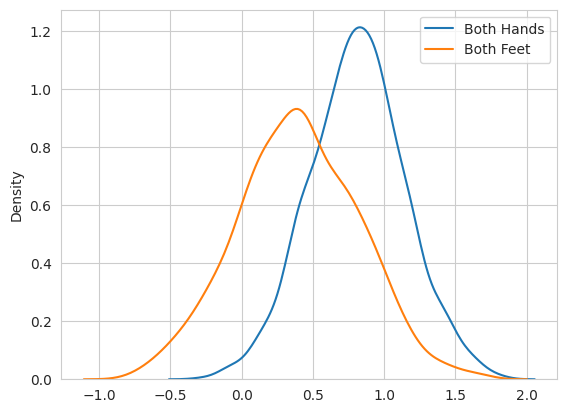

In [13]:
import numpy as np
import seaborn as sns

train_probs = clf.predict_proba(train_embeddings)
val_probs = clf.predict_proba(val_embeddings)
test_probs = clf.predict_proba(test_embeddings)

sns.set_style('whitegrid')
h_mu,h_std = train_probs[train_labels==0][:,0].mean(),train_probs[train_labels==0][:,0].std()
f_mu,f_std = 1-train_probs[train_labels==1][:,1].mean(),train_probs[train_labels==1][:,1].std()

sns.kdeplot(np.random.normal(h_mu,h_std,1000))
sns.kdeplot(np.random.normal(f_mu,f_std,1000))
plt.legend(['Both Hands','Both Feet'])
# sns.kdeplot(val_probs, bw=0.5)
# sns.kdeplot(test_probs, bw=0.5)

In [ ]:
# import matplotlib.pyplot as plt
# A = model.net.gcn.get_adjacency()
# plt.imshow(A)
# plt.colorbar()
# plt.show()